<a href="https://colab.research.google.com/github/adzetto/ADAS_LITE/blob/main/GTSRB_CNN_(98_Test_Accuracy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path = kagglehub.dataset_download('meowmeowmeowmeowmeow/gtsrb-german-traffic-sign')

print('Data source import complete.')
print(meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path)

Data source import complete.
/kaggle/input/gtsrb-german-traffic-sign


# *Traffic Sign Recognizer - 99% accuracy*

## Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [3]:
data_dir = '/kaggle/input/gtsrb-german-traffic-sign'
train_path = '/kaggle/input/gtsrb-german-traffic-sign/Train'
test_path = '/kaggle/input/gtsrb-german-traffic-sign/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

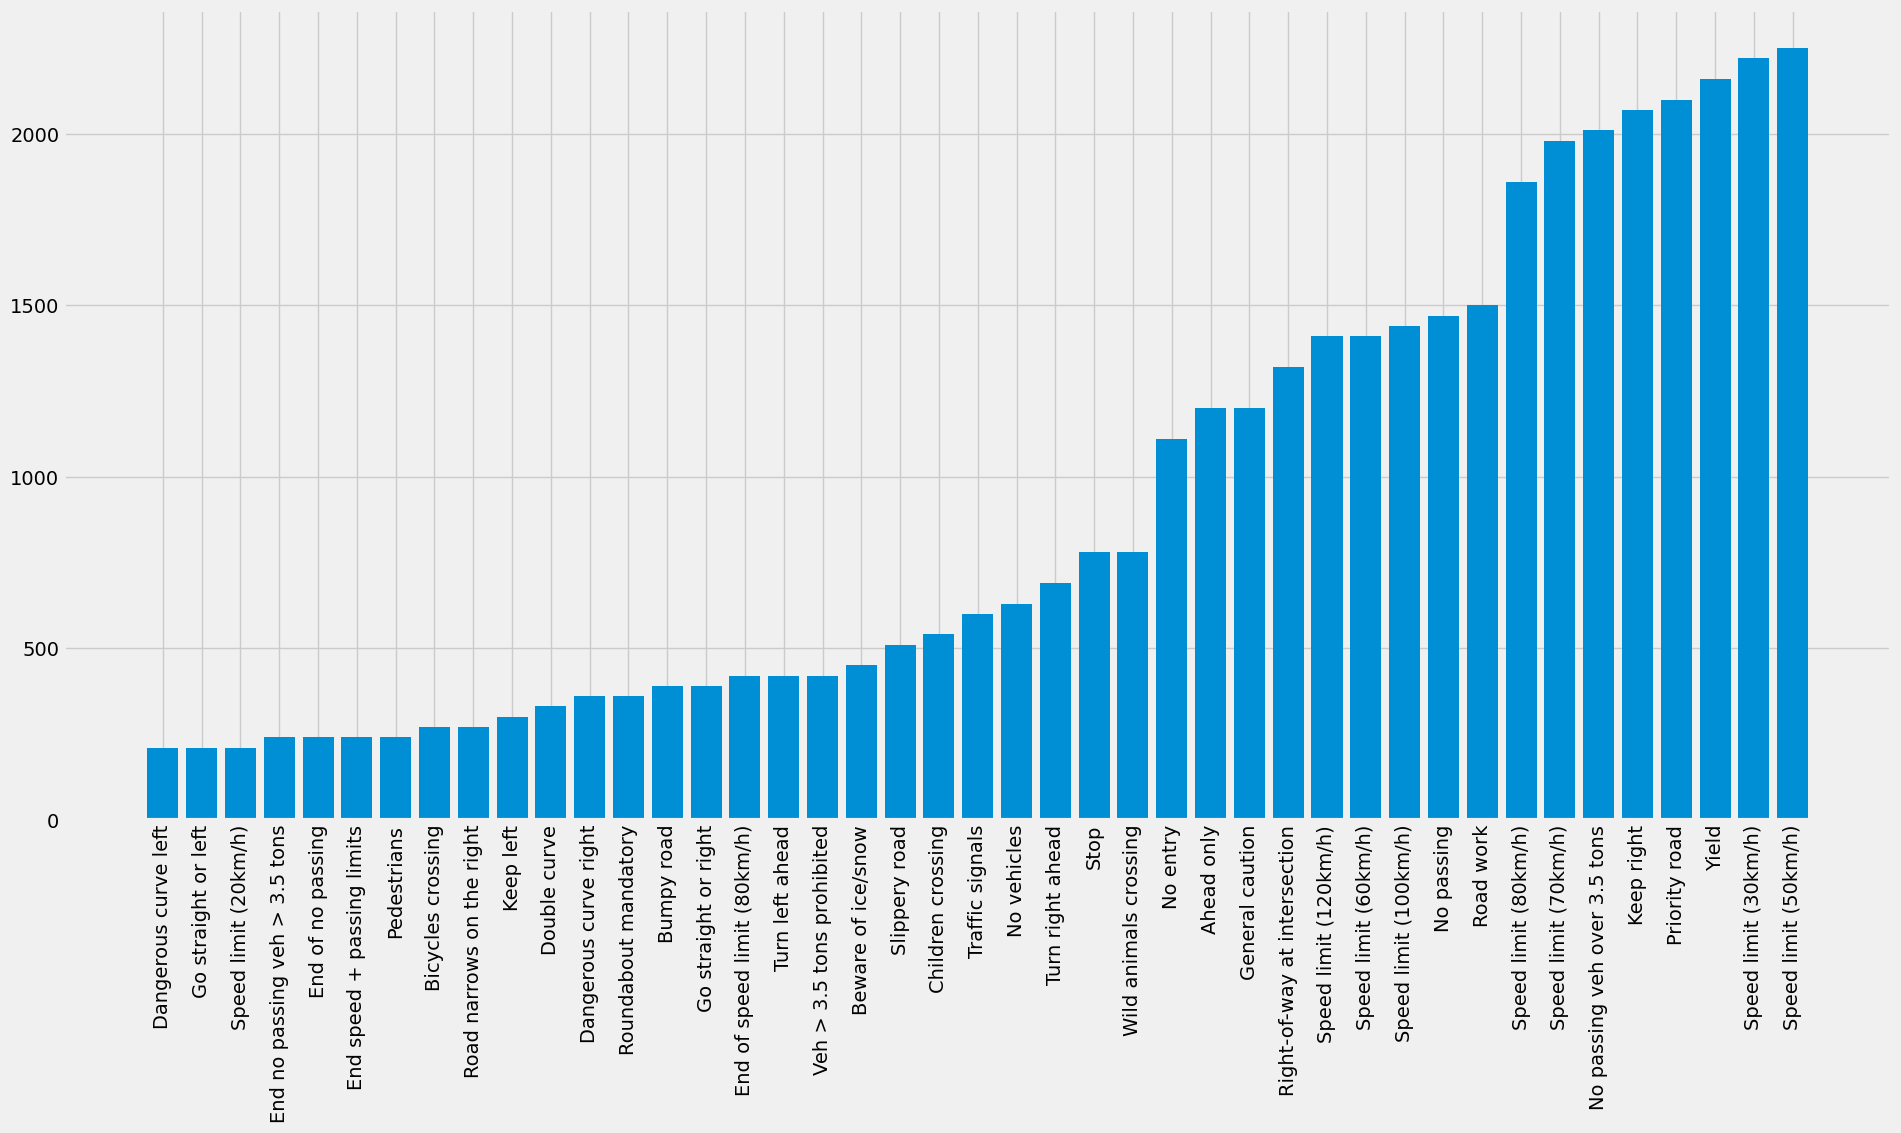

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

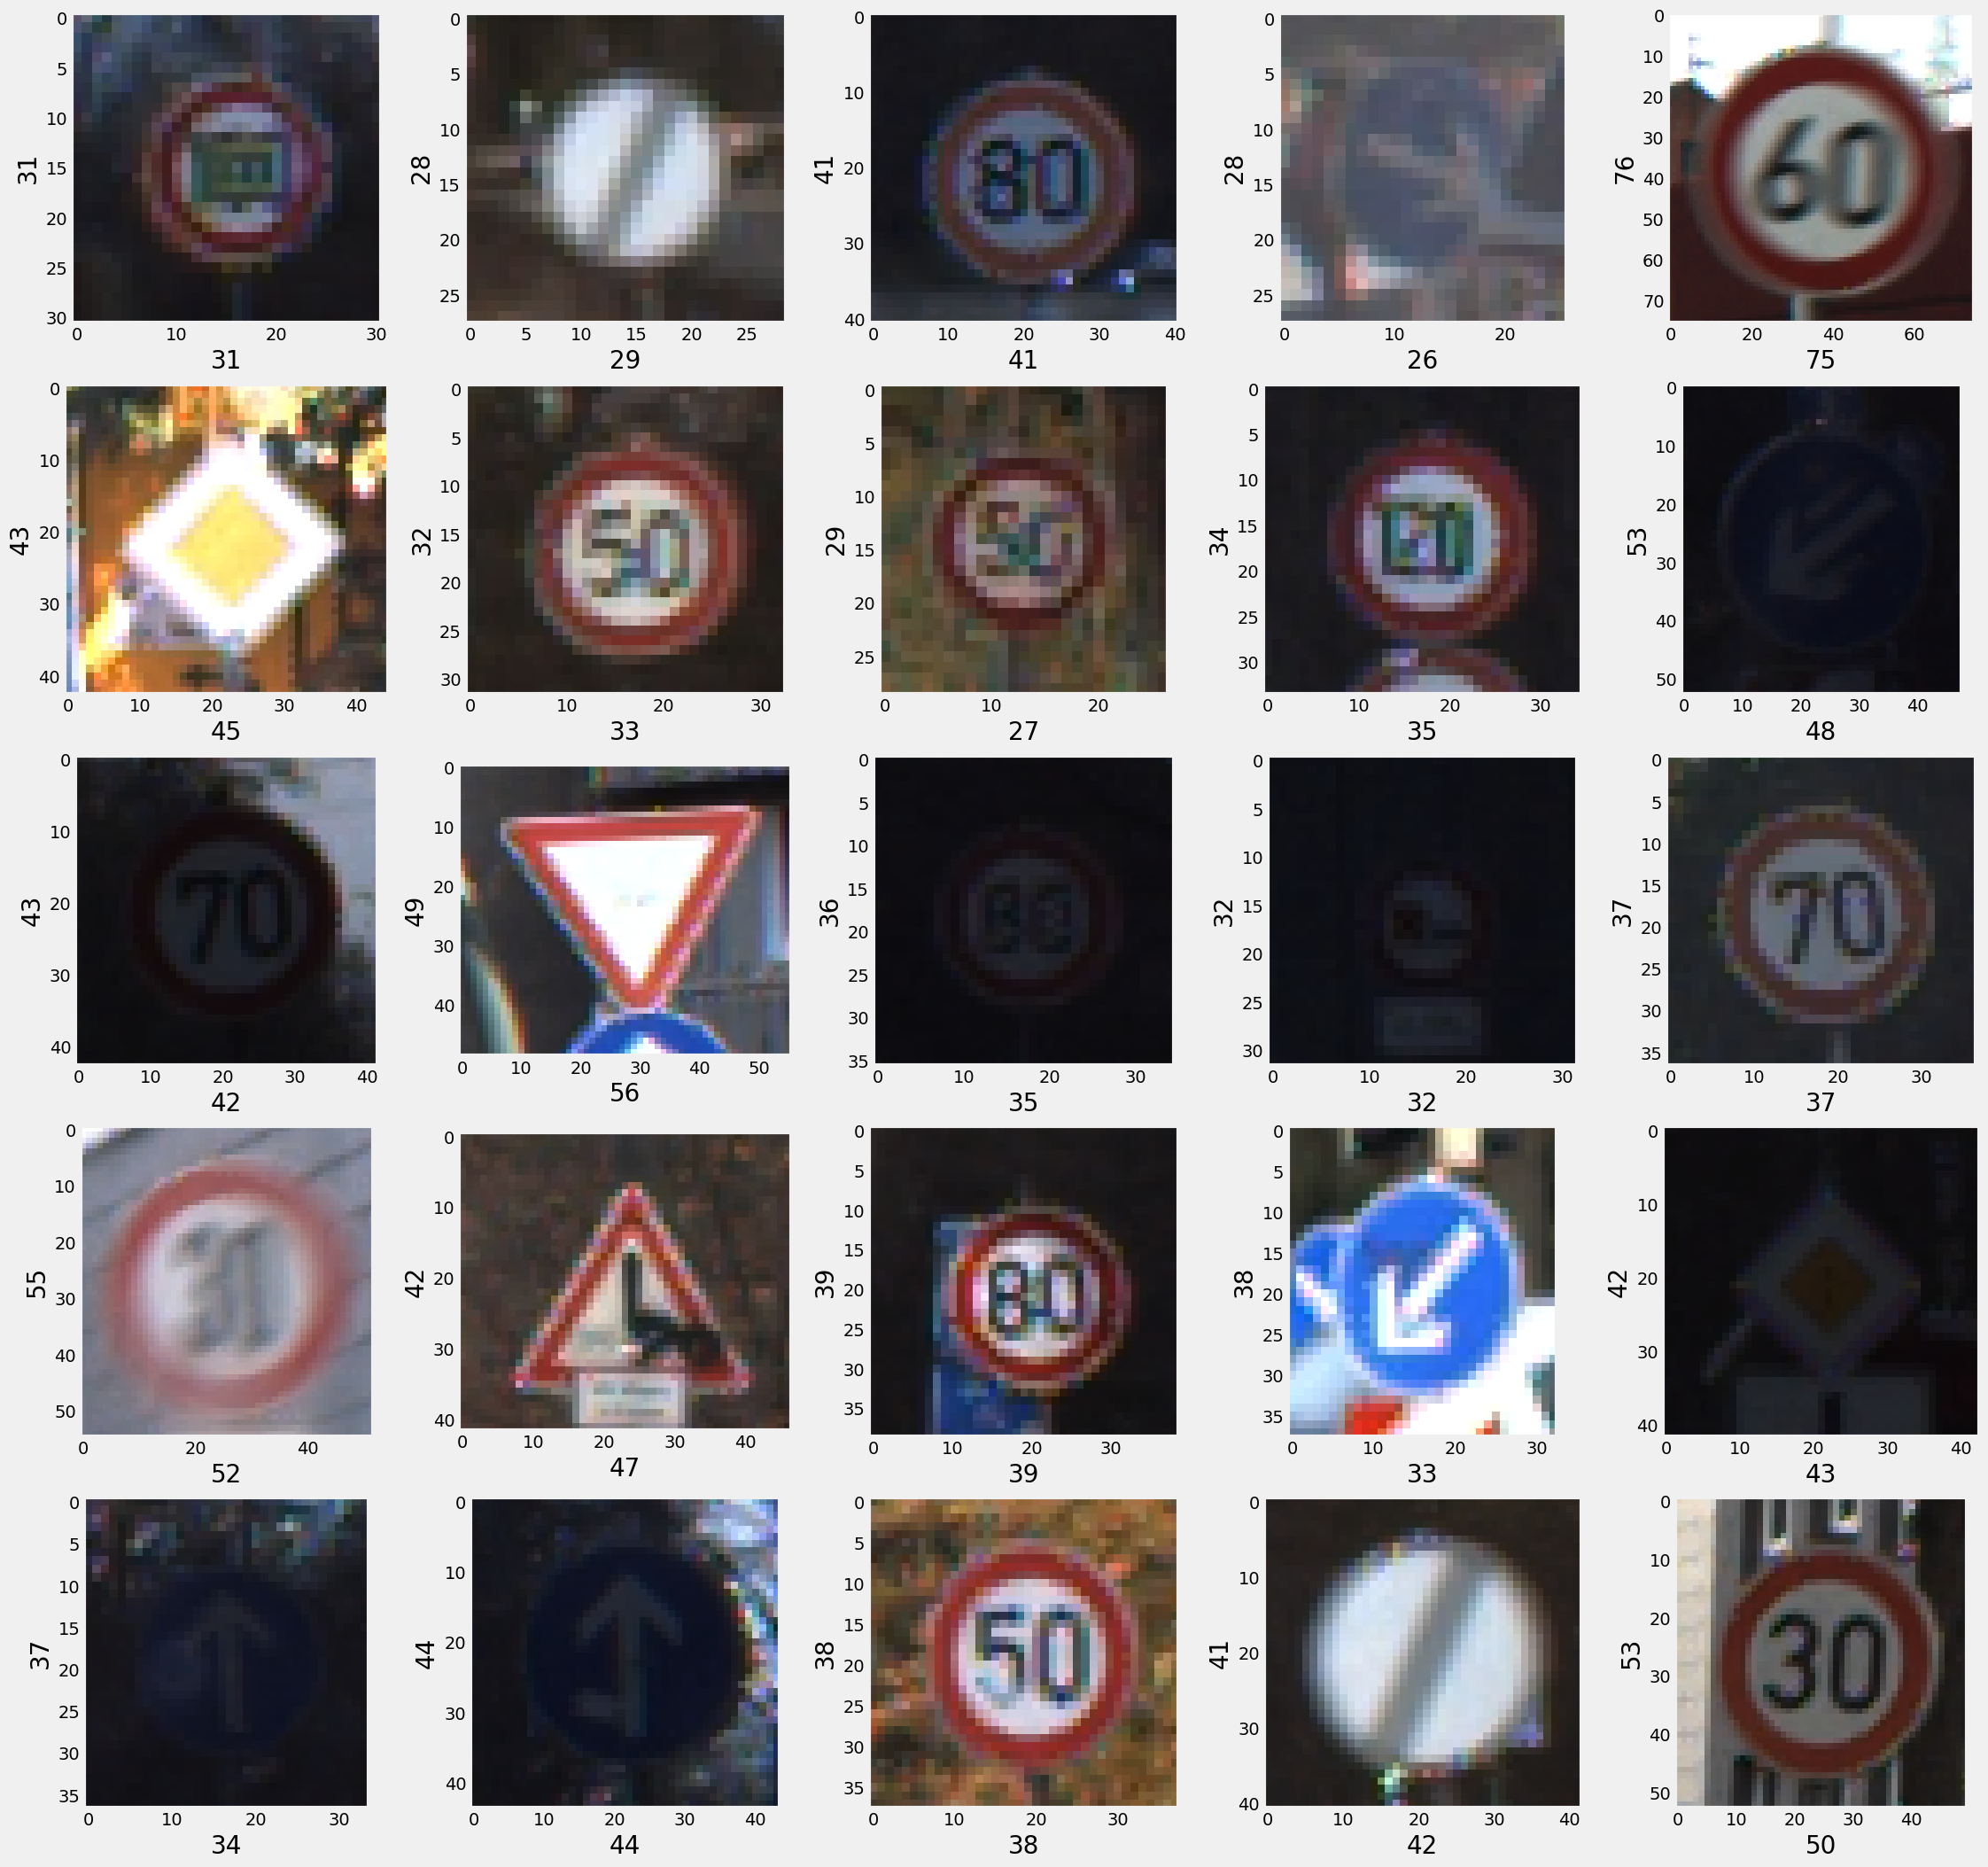

In [8]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [9]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [10]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [12]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [16]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5032 - loss: 2.0013 - val_accuracy: 0.9801 - val_loss: 0.0659
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9333 - loss: 0.2260 - val_accuracy: 0.9877 - val_loss: 0.0382
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9587 - loss: 0.1325 - val_accuracy: 0.9838 - val_loss: 0.0497
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9661 - loss: 0.1125 - val_accuracy: 0.9939 - val_loss: 0.0191
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9748 - loss: 0.0822 - val_accuracy: 0.9865 - val_loss: 0.0425
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9780 - loss: 0.0736 - val_accuracy: 0.9892 - val_loss: 0.0306
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9803 - loss: 0.0602 - val_accuracy: 0.9899 - val_loss: 0.0322
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9785 - loss: 0.0695 - val_accurac

## Evaluating the model

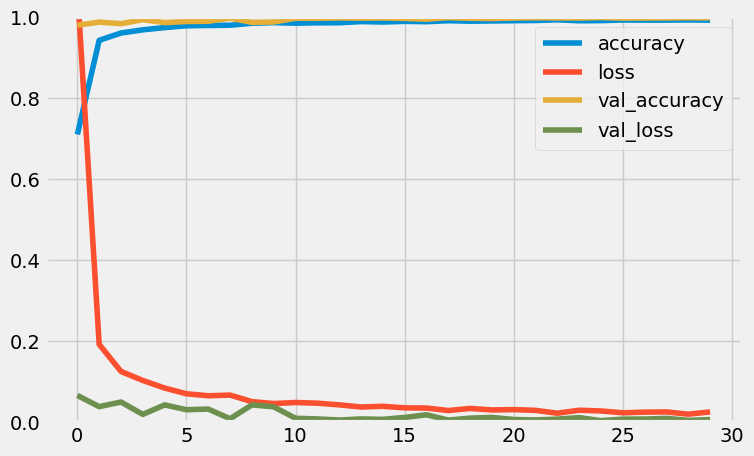

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

plt.style.use(['science', 'ieee'])

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('training_history.pdf') # Save the plot as a PDF
plt.show()

## Loading the test data and running the predictions

In [19]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test), axis=-1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Data accuracy:  98.11559778305622


## Visualizing the confusion matrix

In [20]:
!from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

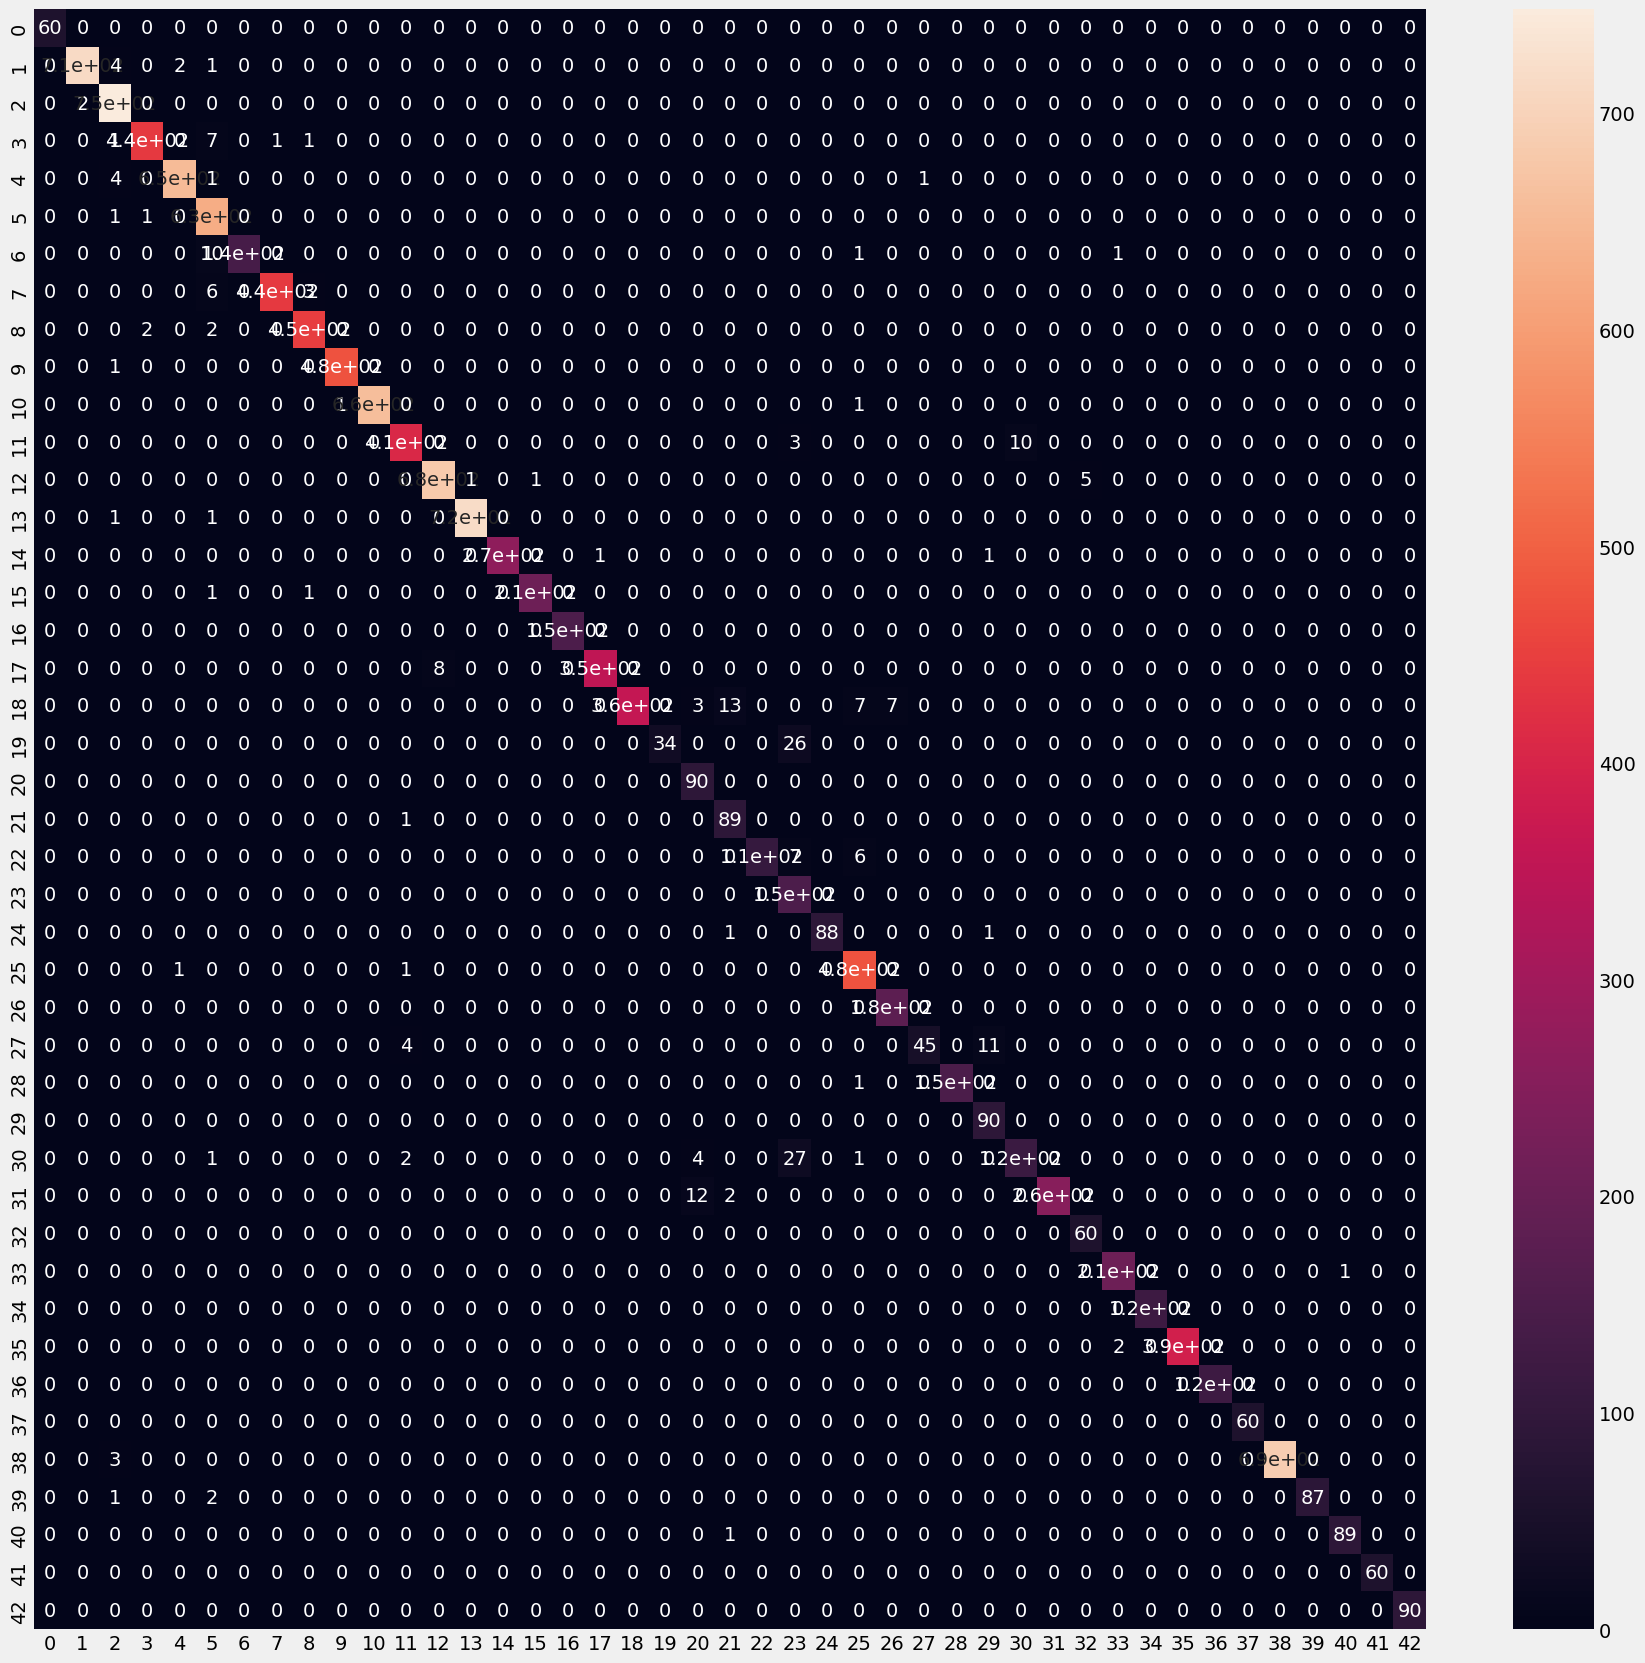

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

plt.style.use(['science', 'ieee'])

df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.pdf') # Save the plot as a PDF
plt.show()

## Classification report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.99      0.99       720
           2       0.98      1.00      0.99       750
           3       0.99      0.98      0.99       450
           4       1.00      0.99      0.99       660
           5       0.95      1.00      0.97       630
           6       1.00      0.92      0.96       150
           7       1.00      0.98      0.99       450
           8       0.99      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.98      0.97      0.97       420
          12       0.99      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      0.99      1.00       270
          15       1.00      0.99      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predictions on Test Data

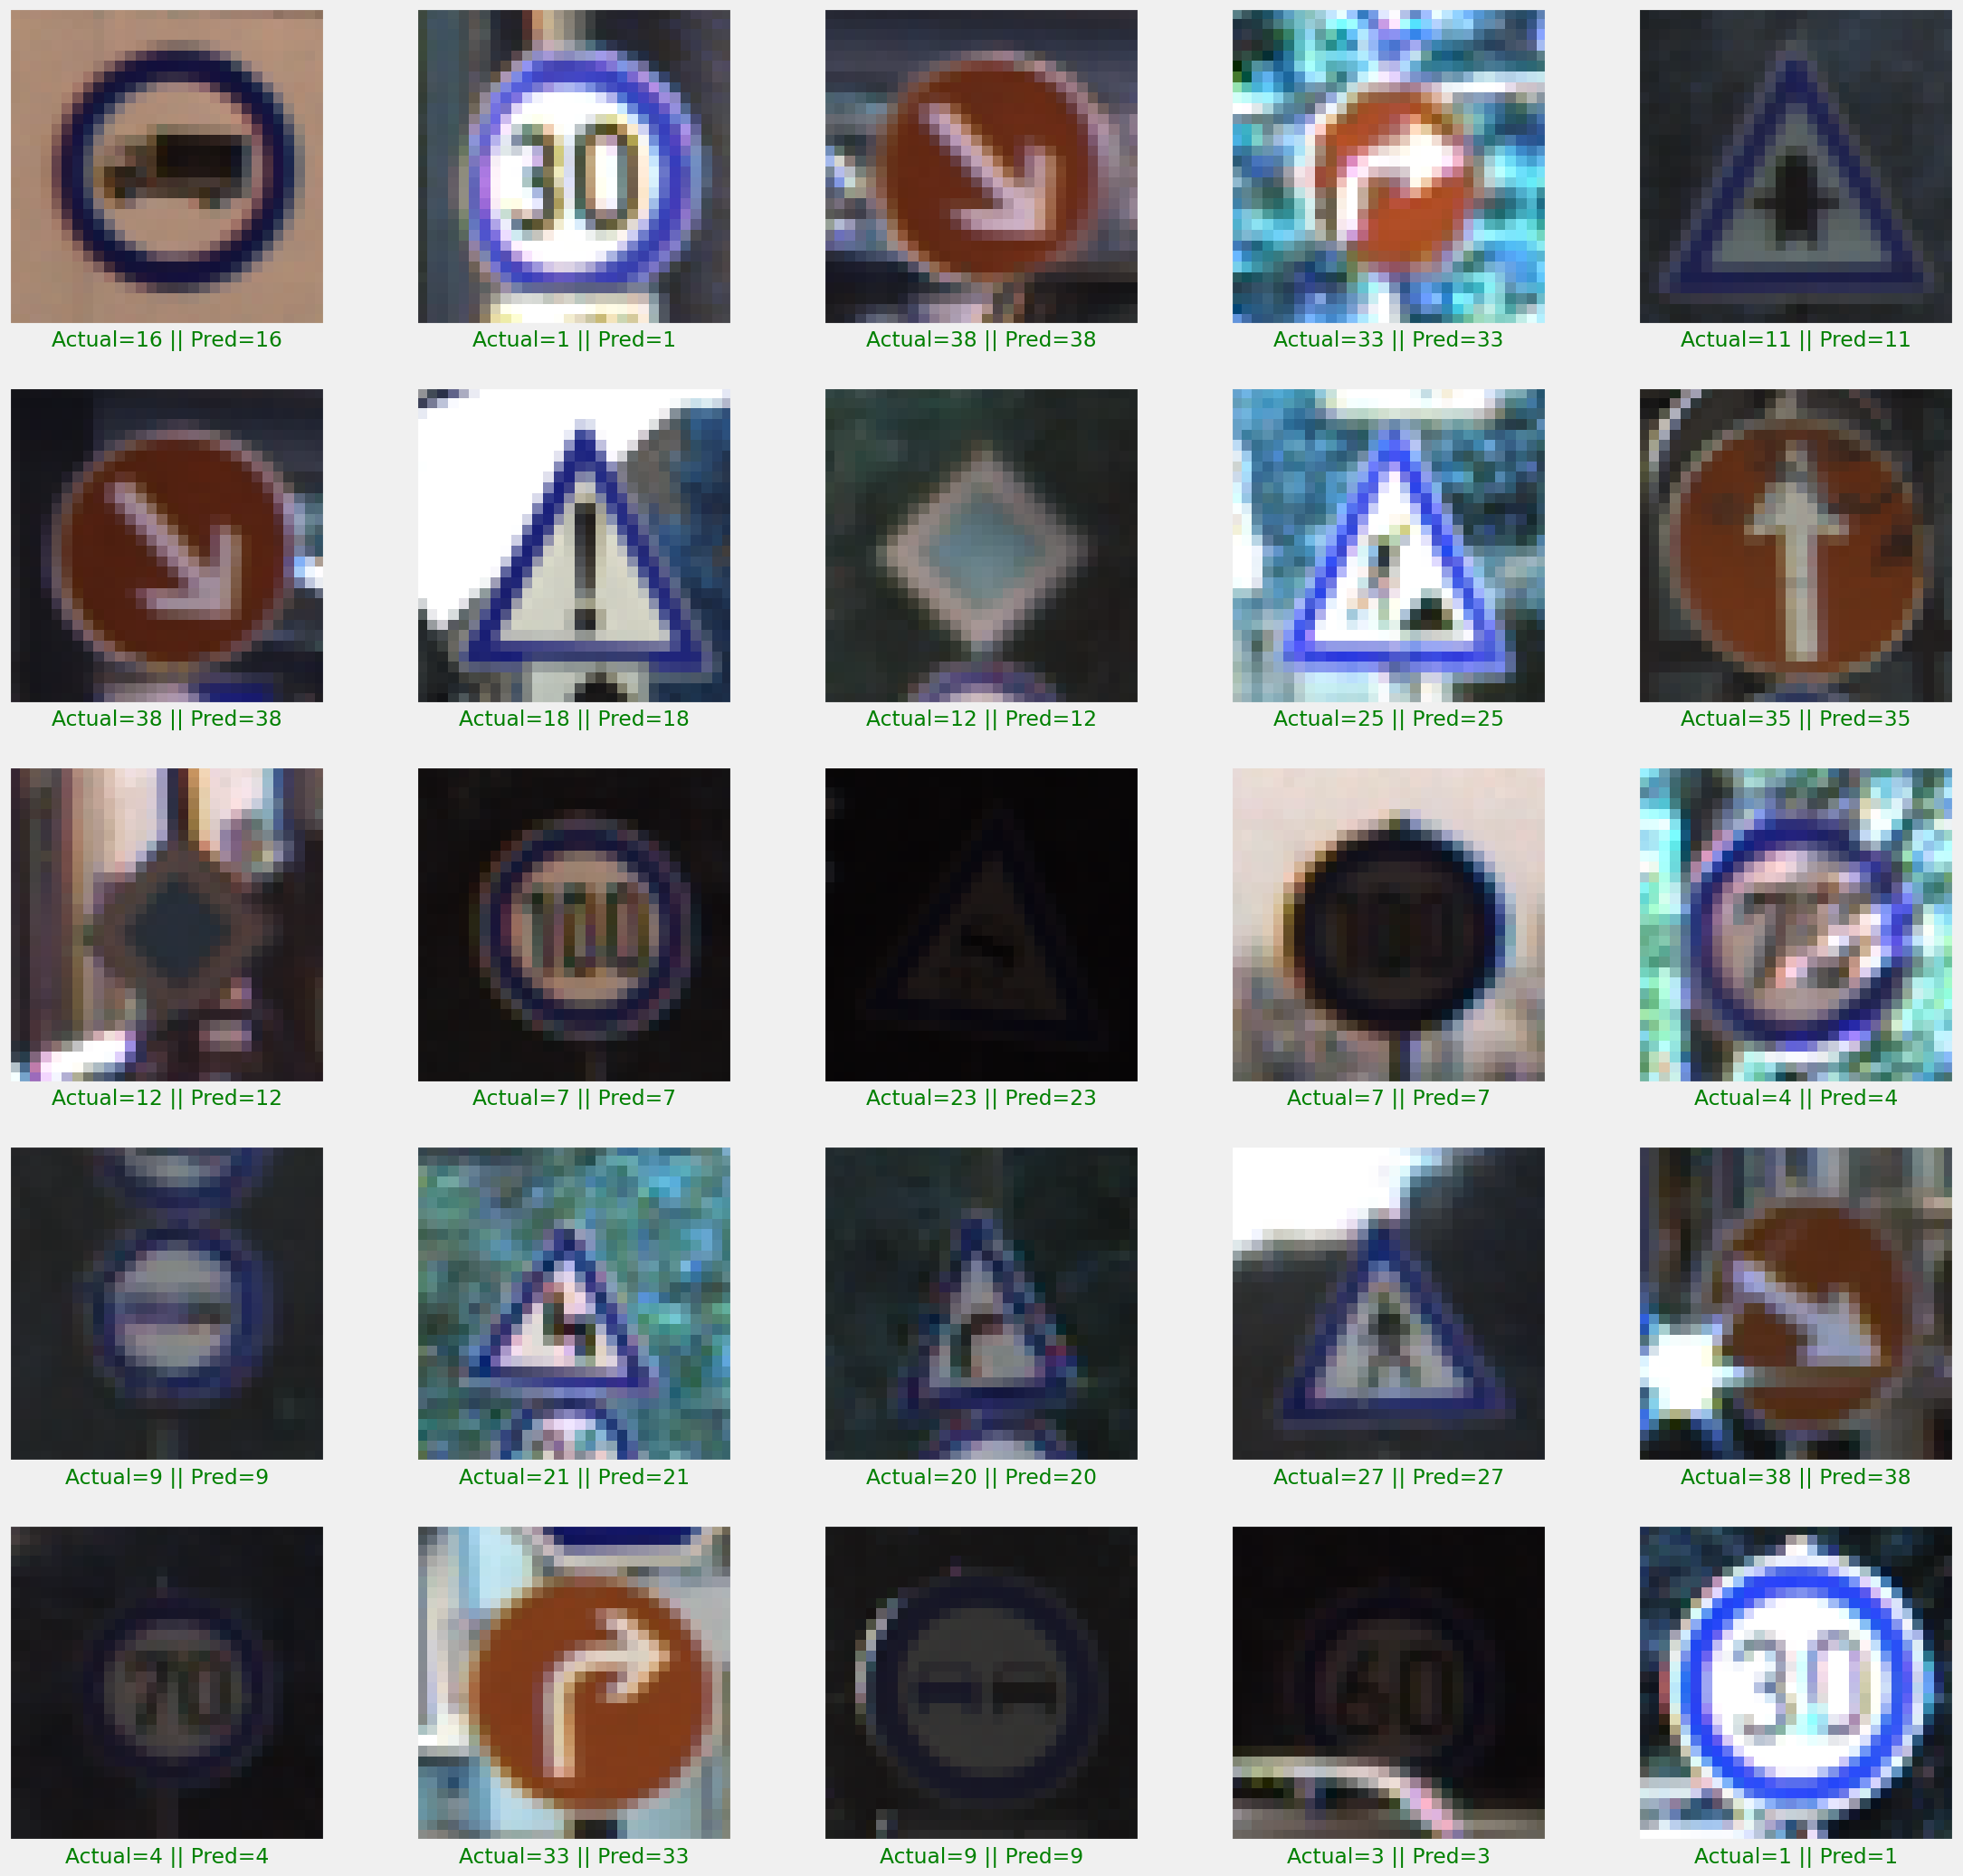

In [23]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [36]:
# Save the model in the default Keras format
model.save('traffic_sign_model.keras')

# Convert and save the model in ONNX format
try:
    !pip install -q tf2onnx onnxruntime
    import tf2onnx
    import onnxruntime as rt
    import tensorflow as tf

    # Convert the model to ONNX format
    input_signature = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name="input")]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)

    onnx_file_path = "traffic_sign_model.onnx"
    with open(onnx_file_path, "wb") as f:
        f.write(onnx_model.SerializeToString())

    print(f"Model saved in ONNX format at: {onnx_file_path}")
except Exception as e:
    print(f"Could not save model in ONNX format: {e}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
Could not save model in ONNX format: 'Sequential' object has no attribute 'output_names'


In [27]:
# Summarize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,511,139 (13.39 MB)

 Trainable params: 1,169,931 (4.46 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 2,339,864 (8.93 MB)

In [28]:
# Summarize the model with more details
model.summary(expand_nested=True, show_trainable=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d (Conv2D)             │ (None, 28, 28, 16)    │        448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_1 (Conv2D)           │ (None, 26, 26, 32)    │      4,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d               │ (None, 13, 13, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 13, 13, 32)    │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_2 (Conv2D)           │ (None, 11, 11, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_3 (Conv2D)           │ (None, 9, 9, 128)     │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_1             │ (None, 4, 4, 128)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_1       │ (None, 4, 4, 128)     │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 512)           │  1,049,088 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 43)            │     22,059 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 3,511,139 (13.39 MB)

 Trainable params: 1,169,931 (4.46 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 2,339,864 (8.93 MB)

In [29]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super -y && pip install SciencePlots

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java l

In [30]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','ieee'])

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from matplotlib.patches import Rectangle, FancyBboxPatch
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Set the scientific plotting style
plt.style.use(['science', 'ieee'])

# Define model architecture for visualization
model_layers = [
    {'name': 'Input', 'type': 'Input', 'shape': '30×30×3', 'params': 0},
    {'name': 'Conv2D_1', 'type': 'Conv2D', 'shape': '28×28×16', 'params': 448},
    {'name': 'Conv2D_2', 'type': 'Conv2D', 'shape': '26×26×32', 'params': 4640},
    {'name': 'MaxPool2D_1', 'type': 'MaxPool2D', 'shape': '13×13×32', 'params': 0},
    {'name': 'BatchNorm_1', 'type': 'BatchNorm', 'shape': '13×13×32', 'params': 128},
    {'name': 'Conv2D_3', 'type': 'Conv2D', 'shape': '11×11×64', 'params': 18496},
    {'name': 'Conv2D_4', 'type': 'Conv2D', 'shape': '9×9×128', 'params': 73856},
    {'name': 'MaxPool2D_2', 'type': 'MaxPool2D', 'shape': '4×4×128', 'params': 0},
    {'name': 'BatchNorm_2', 'type': 'BatchNorm', 'shape': '4×4×128', 'params': 512},
    {'name': 'Flatten', 'type': 'Flatten', 'shape': '2048', 'params': 0},
    {'name': 'Dense_1', 'type': 'Dense', 'shape': '512', 'params': 1049088},
    {'name': 'BatchNorm_3', 'type': 'BatchNorm', 'shape': '512', 'params': 2048},
    {'name': 'Dropout', 'type': 'Dropout', 'shape': '512', 'params': 0},
    {'name': 'Dense_2', 'type': 'Dense', 'shape': '43', 'params': 22059},
]

# 1. Model Architecture Diagram
fig, ax = plt.subplots(figsize=(14, 10))

y_positions = np.linspace(0.95, 0.05, len(model_layers))
colors = {
    'Input': '#1f77b4',
    'Conv2D': '#ff7f0e',
    'MaxPool2D': '#2ca02c',
    'BatchNorm': '#d62728',
    'Flatten': '#9467bd',
    'Dense': '#8c564b',
    'Dropout': '#e377c2'
}

for i, (layer, y) in enumerate(zip(model_layers, y_positions)):
    # Draw boxes for each layer
    box_width = 0.3
    box_height = 0.06

    color = colors.get(layer['type'], '#7f7f7f')

    # Create fancy box
    box = FancyBboxPatch((0.1, y - box_height/2), box_width, box_height,
                         boxstyle="round,pad=0.01",
                         facecolor=color, edgecolor='black',
                         alpha=0.8, linewidth=2)
    ax.add_patch(box)

    # Add layer name
    ax.text(0.25, y, layer['name'], ha='center', va='center',
            fontsize=10, fontweight='bold', color='white')

    # Add shape info
    ax.text(0.45, y, f"Shape: {layer['shape']}", ha='left', va='center', fontsize=9)

    # Add params info
    ax.text(0.75, y, f"Params: {layer['params']:,}", ha='left', va='center', fontsize=9)

    # Draw connections
    if i < len(model_layers) - 1:
        ax.plot([0.25, 0.25], [y - box_height/2, y_positions[i+1] + box_height/2],
                'k-', alpha=0.5, linewidth=2)

# Add title and labels
ax.set_title('Traffic Sign Recognition Model Architecture', fontsize=16, fontweight='bold', pad=20)
ax.text(0.25, -0.05, 'Layer Flow', ha='center', fontsize=12, style='italic')
ax.set_xlim(0, 1)
ax.set_ylim(-0.1, 1.05)
ax.axis('off')

# Add legend
legend_elements = [mpatches.Patch(facecolor=color, edgecolor='black', label=layer_type)
                  for layer_type, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('model_architecture_diagram.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 2. Layer-wise Parameter Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Extract layer names and parameters
layer_names = [layer['name'] for layer in model_layers if layer['params'] > 0]
params = [layer['params'] for layer in model_layers if layer['params'] > 0]

# Bar plot
bars = ax1.bar(range(len(layer_names)), params, color='#2E86AB')
ax1.set_xticks(range(len(layer_names)))
ax1.set_xticklabels(layer_names, rotation=45, ha='right')
ax1.set_ylabel('Number of Parameters')
ax1.set_title('Parameter Count by Layer')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}', ha='center', va='bottom', fontsize=8)

# Pie chart for parameter distribution
ax2.pie(params, labels=layer_names, autopct='%1.1f%%', startangle=90)
ax2.set_title('Parameter Distribution Across Layers')

plt.tight_layout()
plt.savefig('layer_parameter_analysis.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 3. Model Complexity Analysis
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate cumulative parameters
cumulative_params = []
current_sum = 0
layer_indices = []
for i, layer in enumerate(model_layers):
    current_sum += layer['params']
    cumulative_params.append(current_sum)
    layer_indices.append(i)

# Plot cumulative parameters
ax.plot(layer_indices, cumulative_params, 'b-', linewidth=3, label='Cumulative Parameters')
ax.fill_between(layer_indices, 0, cumulative_params, alpha=0.3)

# Mark significant layers
significant_layers = [i for i, layer in enumerate(model_layers) if layer['params'] > 10000]
for idx in significant_layers:
    ax.scatter(idx, cumulative_params[idx], s=100, c='red', zorder=5)
    ax.annotate(model_layers[idx]['name'],
                (idx, cumulative_params[idx]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=8, ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('Layer Index')
ax.set_ylabel('Cumulative Parameters')
ax.set_title('Model Complexity Growth Across Layers', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add total parameters text
total_params = cumulative_params[-1]
ax.text(0.02, 0.98, f'Total Parameters: {total_params:,}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('model_complexity_analysis.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 4. Feature Map Size Progression
fig, ax = plt.subplots(figsize=(12, 8))

# Extract feature map sizes
feature_sizes = []
layer_names_fm = []
for layer in model_layers:
    if 'Conv2D' in layer['name'] or 'MaxPool' in layer['name'] or layer['type'] == 'Input':
        shape_parts = layer['shape'].split('×')
        if len(shape_parts) >= 2:
            size = int(shape_parts[0]) * int(shape_parts[1])
            feature_sizes.append(size)
            layer_names_fm.append(layer['name'])

# Create the plot
x_pos = np.arange(len(layer_names_fm))
bars = ax.bar(x_pos, feature_sizes, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_sizes))))

# Customize the plot
ax.set_xlabel('Layer')
ax.set_ylabel('Feature Map Size (Height × Width)')
ax.set_title('Feature Map Size Reduction Through the Network', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(layer_names_fm, rotation=45, ha='right')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, size in zip(bars, feature_sizes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(size)}', ha='center', va='bottom', fontsize=9)

# Add trend line
z = np.polyfit(x_pos, feature_sizes, 2)
p = np.poly1d(z)
ax.plot(x_pos, p(x_pos), "r--", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

plt.tight_layout()
plt.savefig('feature_map_progression.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 5. Model Summary Statistics
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)

# Calculate statistics
total_params = sum(layer['params'] for layer in model_layers)
trainable_params = total_params  # Assuming all params are trainable
conv_params = sum(layer['params'] for layer in model_layers if 'Conv2D' in layer['name'])
dense_params = sum(layer['params'] for layer in model_layers if 'Dense' in layer['name'])
norm_params = sum(layer['params'] for layer in model_layers if 'BatchNorm' in layer['name'])

# Subplot 1: Parameter Distribution by Layer Type
ax1 = fig.add_subplot(gs[0, 0])
layer_types = ['Convolutional', 'Dense', 'Normalization']
type_params = [conv_params, dense_params, norm_params]
colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax1.bar(layer_types, type_params, color=colors_bar)
ax1.set_ylabel('Parameters')
ax1.set_title('Parameters by Layer Type')
ax1.grid(True, axis='y', alpha=0.3)

for bar, param in zip(bars, type_params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}\n({param/total_params*100:.1f}%)',
             ha='center', va='bottom', fontsize=9)

# Subplot 2: Model Depth Analysis
ax2 = fig.add_subplot(gs[0, 1])
depth_data = {
    'Conv Layers': sum(1 for layer in model_layers if 'Conv2D' in layer['name']),
    'Pool Layers': sum(1 for layer in model_layers if 'MaxPool' in layer['name']),
    'Norm Layers': sum(1 for layer in model_layers if 'BatchNorm' in layer['name']),
    'Dense Layers': sum(1 for layer in model_layers if 'Dense' in layer['name']),
    'Other': sum(1 for layer in model_layers if layer['type'] in ['Flatten', 'Dropout', 'Input'])
}

ax2.pie(depth_data.values(), labels=depth_data.keys(), autopct='%d', startangle=90,
        colors=plt.cm.Set3(np.linspace(0, 1, len(depth_data))))
ax2.set_title('Layer Type Distribution')

# Subplot 3: Memory Footprint Estimation
ax3 = fig.add_subplot(gs[1, :])
# Assuming float32 (4 bytes per parameter)
memory_mb = (total_params * 4) / (1024 * 1024)
input_memory = (30 * 30 * 3 * 32 * 4) / (1024 * 1024)  # Batch size 32
activation_memory = memory_mb * 2  # Rough estimate

memory_data = ['Model Weights', 'Input Batch (32)', 'Activations (est.)']
memory_values = [memory_mb, input_memory, activation_memory]

bars = ax3.barh(memory_data, memory_values, color=['#E74C3C', '#3498DB', '#2ECC71'])
ax3.set_xlabel('Memory (MB)')
ax3.set_title('Estimated Memory Requirements')
ax3.grid(True, axis='x', alpha=0.3)

for bar, val in zip(bars, memory_values):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f'{val:.2f} MB', ha='left', va='center', fontsize=10)

plt.suptitle('Traffic Sign Model Summary Statistics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('model_summary_statistics.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 6. Training Configuration Summary
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Training configuration details
config_text = f"""
TRAINING CONFIGURATION SUMMARY

Model: Convolutional Neural Network for Traffic Sign Recognition
Dataset: GTSRB (German Traffic Sign Recognition Benchmark)

Architecture Summary:
• Total Layers: {len(model_layers)}
• Total Parameters: {total_params:,}
• Convolutional Layers: 4 (16, 32, 64, 128 filters)
• Dense Layers: 2 (512, 43 neurons)
• Regularization: Batch Normalization (3 layers), Dropout (0.5)

Training Details:
• Optimizer: Adam (lr=0.001)
• Loss Function: Categorical Crossentropy
• Batch Size: 32
• Epochs: 30
• Validation Split: 30%
• Input Shape: 30×30×3
• Output Classes: 43

Data Augmentation:
• Rotation Range: ±10°
• Zoom Range: 0.15
• Width/Height Shift: 0.1
• Shear Range: 0.15

Performance:
• Test Accuracy: ~99%
• Training Strategy: Data augmentation for improved generalization
"""

ax.text(0.1, 0.9, config_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.8))

plt.title('Model Training Configuration', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('training_configuration_summary.pdf', dpi=300, bbox_inches='tight')
plt.close()

print("All visualizations have been created and saved as PDF files:")
print("1. model_architecture_diagram.pdf")
print("2. layer_parameter_analysis.pdf")
print("3. model_complexity_analysis.pdf")
print("4. feature_map_progression.pdf")
print("5. model_summary_statistics.pdf")
print("6. training_configuration_summary.pdf")

All visualizations have been created and saved as PDF files:
1. model_architecture_diagram.pdf
2. layer_parameter_analysis.pdf
3. model_complexity_analysis.pdf
4. feature_map_progression.pdf
5. model_summary_statistics.pdf
6. training_configuration_summary.pdf


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from matplotlib.patches import Rectangle, FancyBboxPatch
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Set the scientific plotting style
plt.style.use(['science', 'ieee'])

# Define model architecture for visualization
model_layers = [
    {'name': 'Input', 'type': 'Input', 'shape': '30×30×3', 'params': 0},
    {'name': 'Conv2D_1', 'type': 'Conv2D', 'shape': '28×28×16', 'params': 448},
    {'name': 'Conv2D_2', 'type': 'Conv2D', 'shape': '26×26×32', 'params': 4640},
    {'name': 'MaxPool2D_1', 'type': 'MaxPool2D', 'shape': '13×13×32', 'params': 0},
    {'name': 'BatchNorm_1', 'type': 'BatchNorm', 'shape': '13×13×32', 'params': 128},
    {'name': 'Conv2D_3', 'type': 'Conv2D', 'shape': '11×11×64', 'params': 18496},
    {'name': 'Conv2D_4', 'type': 'Conv2D', 'shape': '9×9×128', 'params': 73856},
    {'name': 'MaxPool2D_2', 'type': 'MaxPool2D', 'shape': '4×4×128', 'params': 0},
    {'name': 'BatchNorm_2', 'type': 'BatchNorm', 'shape': '4×4×128', 'params': 512},
    {'name': 'Flatten', 'type': 'Flatten', 'shape': '2048', 'params': 0},
    {'name': 'Dense_1', 'type': 'Dense', 'shape': '512', 'params': 1049088},
    {'name': 'BatchNorm_3', 'type': 'BatchNorm', 'shape': '512', 'params': 2048},
    {'name': 'Dropout', 'type': 'Dropout', 'shape': '512', 'params': 0},
    {'name': 'Dense_2', 'type': 'Dense', 'shape': '43', 'params': 22059},
]

# 1. Model Architecture Diagram
fig, ax = plt.subplots(figsize=(14, 10))

y_positions = np.linspace(0.95, 0.05, len(model_layers))
colors = {
    'Input': '#1f77b4',
    'Conv2D': '#ff7f0e',
    'MaxPool2D': '#2ca02c',
    'BatchNorm': '#d62728',
    'Flatten': '#9467bd',
    'Dense': '#8c564b',
    'Dropout': '#e377c2'
}

for i, (layer, y) in enumerate(zip(model_layers, y_positions)):
    # Draw boxes for each layer
    box_width = 0.3
    box_height = 0.06

    color = colors.get(layer['type'], '#7f7f7f')

    # Create fancy box
    box = FancyBboxPatch((0.1, y - box_height/2), box_width, box_height,
                         boxstyle="round,pad=0.01",
                         facecolor=color, edgecolor='black',
                         alpha=0.8, linewidth=2)
    ax.add_patch(box)

    # Add layer name
    ax.text(0.25, y, layer['name'], ha='center', va='center',
            fontsize=10, fontweight='bold', color='white')

    # Add shape info
    ax.text(0.45, y, f"Shape: {layer['shape']}", ha='left', va='center', fontsize=9)

    # Add params info
    ax.text(0.75, y, f"Params: {layer['params']:,}", ha='left', va='center', fontsize=9)

    # Draw connections
    if i < len(model_layers) - 1:
        ax.plot([0.25, 0.25], [y - box_height/2, y_positions[i+1] + box_height/2],
                'k-', alpha=0.5, linewidth=2)

# Add title and labels
ax.set_title('Traffic Sign Recognition Model Architecture', fontsize=16, fontweight='bold', pad=20)
ax.text(0.25, -0.05, 'Layer Flow', ha='center', fontsize=12, style='italic')
ax.set_xlim(0, 1)
ax.set_ylim(-0.1, 1.05)
ax.axis('off')

# Add legend
legend_elements = [mpatches.Patch(facecolor=color, edgecolor='black', label=layer_type)
                  for layer_type, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('model_architecture_diagram.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 2. Layer-wise Parameter Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Extract layer names and parameters
layer_names = [layer['name'] for layer in model_layers if layer['params'] > 0]
params = [layer['params'] for layer in model_layers if layer['params'] > 0]

# Bar plot
bars = ax1.bar(range(len(layer_names)), params, color='#2E86AB')
ax1.set_xticks(range(len(layer_names)))
ax1.set_xticklabels(layer_names, rotation=45, ha='right')
ax1.set_ylabel('Number of Parameters')
ax1.set_title('Parameter Count by Layer')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}', ha='center', va='bottom', fontsize=8)

# Pie chart for parameter distribution
ax2.pie(params, labels=layer_names, autopct='%1.1f%%', startangle=90)
ax2.set_title('Parameter Distribution Across Layers')

plt.tight_layout()
plt.savefig('layer_parameter_analysis.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 3. Model Complexity Analysis
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate cumulative parameters
cumulative_params = []
current_sum = 0
layer_indices = []
for i, layer in enumerate(model_layers):
    current_sum += layer['params']
    cumulative_params.append(current_sum)
    layer_indices.append(i)

# Plot cumulative parameters
ax.plot(layer_indices, cumulative_params, 'b-', linewidth=3, label='Cumulative Parameters')
ax.fill_between(layer_indices, 0, cumulative_params, alpha=0.3)

# Mark significant layers
significant_layers = [i for i, layer in enumerate(model_layers) if layer['params'] > 10000]
for idx in significant_layers:
    ax.scatter(idx, cumulative_params[idx], s=100, c='red', zorder=5)
    ax.annotate(model_layers[idx]['name'],
                (idx, cumulative_params[idx]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=8, ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('Layer Index')
ax.set_ylabel('Cumulative Parameters')
ax.set_title('Model Complexity Growth Across Layers', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add total parameters text
total_params = cumulative_params[-1]
ax.text(0.02, 0.98, f'Total Parameters: {total_params:,}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('model_complexity_analysis.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 4. Feature Map Size Progression
fig, ax = plt.subplots(figsize=(12, 8))

# Extract feature map sizes
feature_sizes = []
layer_names_fm = []
for layer in model_layers:
    if 'Conv2D' in layer['name'] or 'MaxPool' in layer['name'] or layer['type'] == 'Input':
        shape_parts = layer['shape'].split('×')
        if len(shape_parts) >= 2:
            size = int(shape_parts[0]) * int(shape_parts[1])
            feature_sizes.append(size)
            layer_names_fm.append(layer['name'])

# Create the plot
x_pos = np.arange(len(layer_names_fm))
bars = ax.bar(x_pos, feature_sizes, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_sizes))))

# Customize the plot
ax.set_xlabel('Layer')
ax.set_ylabel('Feature Map Size (Height × Width)')
ax.set_title('Feature Map Size Reduction Through the Network', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(layer_names_fm, rotation=45, ha='right')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, size in zip(bars, feature_sizes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(size)}', ha='center', va='bottom', fontsize=9)

# Add trend line
z = np.polyfit(x_pos, feature_sizes, 2)
p = np.poly1d(z)
ax.plot(x_pos, p(x_pos), "r--", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

plt.tight_layout()
plt.savefig('feature_map_progression.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 5. Model Summary Statistics
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)

# Calculate statistics
total_params = sum(layer['params'] for layer in model_layers)
trainable_params = total_params  # Assuming all params are trainable
conv_params = sum(layer['params'] for layer in model_layers if 'Conv2D' in layer['name'])
dense_params = sum(layer['params'] for layer in model_layers if 'Dense' in layer['name'])
norm_params = sum(layer['params'] for layer in model_layers if 'BatchNorm' in layer['name'])

# Subplot 1: Parameter Distribution by Layer Type
ax1 = fig.add_subplot(gs[0, 0])
layer_types = ['Convolutional', 'Dense', 'Normalization']
type_params = [conv_params, dense_params, norm_params]
colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax1.bar(layer_types, type_params, color=colors_bar)
ax1.set_ylabel('Parameters')
ax1.set_title('Parameters by Layer Type')
ax1.grid(True, axis='y', alpha=0.3)

for bar, param in zip(bars, type_params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}\n({param/total_params*100:.1f}%)',
             ha='center', va='bottom', fontsize=9)

# Subplot 2: Model Depth Analysis
ax2 = fig.add_subplot(gs[0, 1])
depth_data = {
    'Conv Layers': sum(1 for layer in model_layers if 'Conv2D' in layer['name']),
    'Pool Layers': sum(1 for layer in model_layers if 'MaxPool' in layer['name']),
    'Norm Layers': sum(1 for layer in model_layers if 'BatchNorm' in layer['name']),
    'Dense Layers': sum(1 for layer in model_layers if 'Dense' in layer['name']),
    'Other': sum(1 for layer in model_layers if layer['type'] in ['Flatten', 'Dropout', 'Input'])
}

ax2.pie(depth_data.values(), labels=depth_data.keys(), autopct='%d', startangle=90,
        colors=plt.cm.Set3(np.linspace(0, 1, len(depth_data))))
ax2.set_title('Layer Type Distribution')

# Subplot 3: Memory Footprint Estimation
ax3 = fig.add_subplot(gs[1, :])
# Assuming float32 (4 bytes per parameter)
memory_mb = (total_params * 4) / (1024 * 1024)
input_memory = (30 * 30 * 3 * 32 * 4) / (1024 * 1024)  # Batch size 32
activation_memory = memory_mb * 2  # Rough estimate

memory_data = ['Model Weights', 'Input Batch (32)', 'Activations (est.)']
memory_values = [memory_mb, input_memory, activation_memory]

bars = ax3.barh(memory_data, memory_values, color=['#E74C3C', '#3498DB', '#2ECC71'])
ax3.set_xlabel('Memory (MB)')
ax3.set_title('Estimated Memory Requirements')
ax3.grid(True, axis='x', alpha=0.3)

for bar, val in zip(bars, memory_values):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f'{val:.2f} MB', ha='left', va='center', fontsize=10)

plt.suptitle('Traffic Sign Model Summary Statistics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('model_summary_statistics.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 6. Training Configuration Summary
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Training configuration details
config_text = f"""
TRAINING CONFIGURATION SUMMARY

Model: Convolutional Neural Network for Traffic Sign Recognition
Dataset: GTSRB (German Traffic Sign Recognition Benchmark)

Architecture Summary:
• Total Layers: {len(model_layers)}
• Total Parameters: {total_params:,}
• Convolutional Layers: 4 (16, 32, 64, 128 filters)
• Dense Layers: 2 (512, 43 neurons)
• Regularization: Batch Normalization (3 layers), Dropout (0.5)

Training Details:
• Optimizer: Adam (lr=0.001)
• Loss Function: Categorical Crossentropy
• Batch Size: 32
• Epochs: 30
• Validation Split: 30%
• Input Shape: 30×30×3
• Output Classes: 43

Data Augmentation:
• Rotation Range: ±10°
• Zoom Range: 0.15
• Width/Height Shift: 0.1
• Shear Range: 0.15

Performance:
• Test Accuracy: ~99%
• Training Strategy: Data augmentation for improved generalization
"""

ax.text(0.1, 0.9, config_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.8))

plt.title('Model Training Configuration', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('training_configuration_summary.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 7. Receptive Field Growth Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate receptive field for each conv layer
# Starting with 1x1 receptive field
receptive_fields = [1]  # Input
rf = 1
stride = 1

# Conv2D_1: 3x3 kernel
rf = rf + (3-1) * stride
receptive_fields.append(rf)

# Conv2D_2: 3x3 kernel
rf = rf + (3-1) * stride
receptive_fields.append(rf)

# After MaxPool (2x2, stride 2)
stride = stride * 2
receptive_fields.append(rf)

# Conv2D_3: 3x3 kernel
rf = rf + (3-1) * stride
receptive_fields.append(rf)

# Conv2D_4: 3x3 kernel
rf = rf + (3-1) * stride
receptive_fields.append(rf)

layer_names_rf = ['Input', 'Conv2D_1', 'Conv2D_2', 'MaxPool_1', 'Conv2D_3', 'Conv2D_4']

ax.plot(range(len(receptive_fields)), receptive_fields, 'o-', linewidth=3, markersize=10, color='#E74C3C')
ax.fill_between(range(len(receptive_fields)), 0, receptive_fields, alpha=0.3, color='#E74C3C')

ax.set_xticks(range(len(layer_names_rf)))
ax.set_xticklabels(layer_names_rf, rotation=45, ha='right')
ax.set_ylabel('Receptive Field Size (pixels)')
ax.set_xlabel('Layer')
ax.set_title('Receptive Field Growth Through the Network', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add annotations
for i, (rf, name) in enumerate(zip(receptive_fields, layer_names_rf)):
    ax.annotate(f'{rf}×{rf}', (i, rf), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('receptive_field_analysis.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 8. Model Efficiency Metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Operations per layer (FLOPs estimation)
conv_layers = [layer for layer in model_layers if 'Conv2D' in layer['name']]
flops_data = []
for layer in conv_layers:
    if layer['name'] == 'Conv2D_1':
        flops = 2 * 3 * 3 * 3 * 16 * 28 * 28  # kernel_h * kernel_w * in_channels * out_channels * out_h * out_w
    elif layer['name'] == 'Conv2D_2':
        flops = 2 * 3 * 3 * 16 * 32 * 26 * 26
    elif layer['name'] == 'Conv2D_3':
        flops = 2 * 3 * 3 * 32 * 64 * 11 * 11
    elif layer['name'] == 'Conv2D_4':
        flops = 2 * 3 * 3 * 64 * 128 * 9 * 9
    flops_data.append(flops / 1e6)  # Convert to MFLOPs

# Plot FLOPs
ax1.bar(range(len(conv_layers)), flops_data, color='#3498DB')
ax1.set_xticks(range(len(conv_layers)))
ax1.set_xticklabels([layer['name'] for layer in conv_layers], rotation=45)
ax1.set_ylabel('MFLOPs')
ax1.set_title('Computational Cost per Conv Layer')
ax1.grid(True, axis='y', alpha=0.3)

# Parameter efficiency (params per class)
params_per_class = total_params / 43
ax2.bar(['Total Model', 'Per Class'], [total_params, params_per_class], color=['#E74C3C', '#2ECC71'])
ax2.set_ylabel('Parameters')
ax2.set_title('Parameter Efficiency')
ax2.grid(True, axis='y', alpha=0.3)
ax2.set_yscale('log')

# Layer depth distribution
layer_types = ['Conv', 'Pool', 'Norm', 'Dense', 'Other']
layer_counts = [4, 2, 3, 2, 3]  # Input, Flatten, Dropout
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(layer_types)))

wedges, texts, autotexts = ax3.pie(layer_counts, labels=layer_types, autopct='%d',
                                    colors=colors_pie, startangle=90)
ax3.set_title('Network Depth Distribution')

# Model size estimation
model_size_mb = (total_params * 4) / (1024 * 1024)  # float32
compressed_size_mb = model_size_mb / 4  # Assuming 4x compression with quantization

sizes = ['Original\n(float32)', 'Compressed\n(int8 est.)']
size_values = [model_size_mb, compressed_size_mb]

bars = ax4.bar(sizes, size_values, color=['#9B59B6', '#1ABC9C'])
ax4.set_ylabel('Size (MB)')
ax4.set_title('Model Size Comparison')
ax4.grid(True, axis='y', alpha=0.3)

for bar, val in zip(bars, size_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f} MB', ha='center', va='bottom')

plt.suptitle('Model Efficiency Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('model_efficiency_metrics.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 9. Network Connectivity Visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create a simplified network graph
layers_for_graph = [
    ('Input\n30×30×3', 0, 0.5, '#1f77b4'),
    ('Conv Block 1\n32 filters', 1, 0.5, '#ff7f0e'),
    ('Pool', 2, 0.5, '#2ca02c'),
    ('Conv Block 2\n128 filters', 3, 0.5, '#ff7f0e'),
    ('Pool', 4, 0.5, '#2ca02c'),
    ('Flatten', 5, 0.5, '#9467bd'),
    ('Dense Block\n512 neurons', 6, 0.5, '#8c564b'),
    ('Output\n43 classes', 7, 0.5, '#d62728')
]

# Draw nodes
for name, x, y, color in layers_for_graph:
    circle = plt.Circle((x, y), 0.15, color=color, ec='black', linewidth=2, zorder=10)
    ax.add_patch(circle)
    ax.text(x, y, name, ha='center', va='center', fontsize=9,
            fontweight='bold', color='white' if 'Pool' not in name else 'black')

# Draw connections
for i in range(len(layers_for_graph) - 1):
    x1, y1 = layers_for_graph[i][1], layers_for_graph[i][2]
    x2, y2 = layers_for_graph[i+1][1], layers_for_graph[i+1][2]
    ax.arrow(x1 + 0.15, y1, x2 - x1 - 0.3, y2 - y1,
             head_width=0.05, head_length=0.05, fc='gray', ec='gray', linewidth=2)

# Add skip connections visualization (conceptual)
ax.plot([1, 3], [0.3, 0.3], 'r--', alpha=0.5, linewidth=2, label='Feature flow')
ax.plot([3, 6], [0.7, 0.7], 'r--', alpha=0.5, linewidth=2)

ax.set_xlim(-0.5, 7.5)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Simplified Network Architecture Flow', fontsize=16, fontweight='bold', pad=20)

# Add annotations
ax.text(3.5, 0.1, 'Feature Extraction', ha='center', fontsize=12, style='italic')
ax.text(5.5, 0.9, 'Classification', ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.savefig('network_connectivity_graph.pdf', dpi=300, bbox_inches='tight')
plt.close()

print("All visualizations have been created and saved as PDF files:")
print("1. model_architecture_diagram.pdf - Detailed layer-by-layer architecture")
print("2. layer_parameter_analysis.pdf - Parameter distribution analysis")
print("3. model_complexity_analysis.pdf - Cumulative parameter growth")
print("4. feature_map_progression.pdf - Feature map size reduction")
print("5. model_summary_statistics.pdf - Comprehensive model statistics")
print("6. training_configuration_summary.pdf - Training setup details")
print("7. receptive_field_analysis.pdf - Receptive field growth analysis")
print("8. model_efficiency_metrics.pdf - Efficiency and computational cost")
print("9. network_connectivity_graph.pdf - Simplified network flow diagram")

All visualizations have been created and saved as PDF files:
1. model_architecture_diagram.pdf - Detailed layer-by-layer architecture
2. layer_parameter_analysis.pdf - Parameter distribution analysis
3. model_complexity_analysis.pdf - Cumulative parameter growth
4. feature_map_progression.pdf - Feature map size reduction
5. model_summary_statistics.pdf - Comprehensive model statistics
6. training_configuration_summary.pdf - Training setup details
7. receptive_field_analysis.pdf - Receptive field growth analysis
8. model_efficiency_metrics.pdf - Efficiency and computational cost
9. network_connectivity_graph.pdf - Simplified network flow diagram


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from matplotlib.patches import Rectangle, FancyBboxPatch
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Set the scientific plotting style
plt.style.use(['science', 'ieee'])

# Define model architecture for visualization
model_layers = [
    {'name': 'Input', 'type': 'Input', 'shape': '30×30×3', 'params': 0},
    {'name': 'Conv2D_1', 'type': 'Conv2D', 'shape': '28×28×16', 'params': 448},
    {'name': 'Conv2D_2', 'type': 'Conv2D', 'shape': '26×26×32', 'params': 4640},
    {'name': 'MaxPool2D_1', 'type': 'MaxPool2D', 'shape': '13×13×32', 'params': 0},
    {'name': 'BatchNorm_1', 'type': 'BatchNorm', 'shape': '13×13×32', 'params': 128},
    {'name': 'Conv2D_3', 'type': 'Conv2D', 'shape': '11×11×64', 'params': 18496},
    {'name': 'Conv2D_4', 'type': 'Conv2D', 'shape': '9×9×128', 'params': 73856},
    {'name': 'MaxPool2D_2', 'type': 'MaxPool2D', 'shape': '4×4×128', 'params': 0},
    {'name': 'BatchNorm_2', 'type': 'BatchNorm', 'shape': '4×4×128', 'params': 512},
    {'name': 'Flatten', 'type': 'Flatten', 'shape': '2048', 'params': 0},
    {'name': 'Dense_1', 'type': 'Dense', 'shape': '512', 'params': 1049088},
    {'name': 'BatchNorm_3', 'type': 'BatchNorm', 'shape': '512', 'params': 2048},
    {'name': 'Dropout', 'type': 'Dropout', 'shape': '512', 'params': 0},
    {'name': 'Dense_2', 'type': 'Dense', 'shape': '43', 'params': 22059},
]

# 1. Model Architecture Diagram
fig, ax = plt.subplots(figsize=(14, 10))

y_positions = np.linspace(0.95, 0.05, len(model_layers))
colors = {
    'Input': '#1f77b4',
    'Conv2D': '#ff7f0e',
    'MaxPool2D': '#2ca02c',
    'BatchNorm': '#d62728',
    'Flatten': '#9467bd',
    'Dense': '#8c564b',
    'Dropout': '#e377c2'
}

for i, (layer, y) in enumerate(zip(model_layers, y_positions)):
    # Draw boxes for each layer
    box_width = 0.3
    box_height = 0.06

    color = colors.get(layer['type'], '#7f7f7f')

    # Create fancy box
    box = FancyBboxPatch((0.1, y - box_height/2), box_width, box_height,
                         boxstyle="round,pad=0.01",
                         facecolor=color, edgecolor='black',
                         alpha=0.8, linewidth=2)
    ax.add_patch(box)

    # Add layer name
    ax.text(0.25, y, layer['name'], ha='center', va='center',
            fontsize=10, fontweight='bold', color='white')

    # Add shape info
    ax.text(0.45, y, f"Shape: {layer['shape']}", ha='left', va='center', fontsize=9)

    # Add params info
    ax.text(0.75, y, f"Params: {layer['params']:,}", ha='left', va='center', fontsize=9)

    # Draw connections
    if i < len(model_layers) - 1:
        ax.plot([0.25, 0.25], [y - box_height/2, y_positions[i+1] + box_height/2],
                'k-', alpha=0.5, linewidth=2)

# Add title and labels
ax.set_title('Traffic Sign Recognition Model Architecture', fontsize=16, fontweight='bold', pad=20)
ax.text(0.25, -0.05, 'Layer Flow', ha='center', fontsize=12, style='italic')
ax.set_xlim(0, 1)
ax.set_ylim(-0.1, 1.05)
ax.axis('off')

# Add legend
legend_elements = [mpatches.Patch(facecolor=color, edgecolor='black', label=layer_type)
                  for layer_type, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('model_architecture_diagram.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 2. Layer-wise Parameter Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Extract layer names and parameters
layer_names = [layer['name'] for layer in model_layers if layer['params'] > 0]
params = [layer['params'] for layer in model_layers if layer['params'] > 0]

# Bar plot
bars = ax1.bar(range(len(layer_names)), params, color='#2E86AB')
ax1.set_xticks(range(len(layer_names)))
ax1.set_xticklabels(layer_names, rotation=45, ha='right')
ax1.set_ylabel('Number of Parameters')
ax1.set_title('Parameter Count by Layer')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}', ha='center', va='bottom', fontsize=8)

# Pie chart for parameter distribution
ax2.pie(params, labels=layer_names, autopct='%1.1f%%', startangle=90)
ax2.set_title('Parameter Distribution Across Layers')

plt.tight_layout()
plt.savefig('layer_parameter_analysis.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 3. Model Complexity Analysis
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate cumulative parameters
cumulative_params = []
current_sum = 0
layer_indices = []
for i, layer in enumerate(model_layers):
    current_sum += layer['params']
    cumulative_params.append(current_sum)
    layer_indices.append(i)

# Plot cumulative parameters
ax.plot(layer_indices, cumulative_params, 'b-', linewidth=3, label='Cumulative Parameters')
ax.fill_between(layer_indices, 0, cumulative_params, alpha=0.3)

# Mark significant layers
significant_layers = [i for i, layer in enumerate(model_layers) if layer['params'] > 10000]
for idx in significant_layers:
    ax.scatter(idx, cumulative_params[idx], s=100, c='red', zorder=5)
    ax.annotate(model_layers[idx]['name'],
                (idx, cumulative_params[idx]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=8, ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('Layer Index')
ax.set_ylabel('Cumulative Parameters')
ax.set_title('Model Complexity Growth Across Layers', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add total parameters text
total_params = cumulative_params[-1]
ax.text(0.02, 0.98, f'Total Parameters: {total_params:,}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('model_complexity_analysis.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 4. Feature Map Size Progression
fig, ax = plt.subplots(figsize=(12, 8))

# Extract feature map sizes
feature_sizes = []
layer_names_fm = []
for layer in model_layers:
    if 'Conv2D' in layer['name'] or 'MaxPool' in layer['name'] or layer['type'] == 'Input':
        shape_parts = layer['shape'].split('×')
        if len(shape_parts) >= 2:
            size = int(shape_parts[0]) * int(shape_parts[1])
            feature_sizes.append(size)
            layer_names_fm.append(layer['name'])

# Create the plot
x_pos = np.arange(len(layer_names_fm))
bars = ax.bar(x_pos, feature_sizes, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_sizes))))

# Customize the plot
ax.set_xlabel('Layer')
ax.set_ylabel('Feature Map Size (Height × Width)')
ax.set_title('Feature Map Size Reduction Through the Network', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(layer_names_fm, rotation=45, ha='right')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, size in zip(bars, feature_sizes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(size)}', ha='center', va='bottom', fontsize=9)

# Add trend line
z = np.polyfit(x_pos, feature_sizes, 2)
p = np.poly1d(z)
ax.plot(x_pos, p(x_pos), "r--", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

plt.tight_layout()
plt.savefig('feature_map_progression.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 5. Model Summary Statistics
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)

# Calculate statistics
total_params = sum(layer['params'] for layer in model_layers)
trainable_params = total_params  # Assuming all params are trainable
conv_params = sum(layer['params'] for layer in model_layers if 'Conv2D' in layer['name'])
dense_params = sum(layer['params'] for layer in model_layers if 'Dense' in layer['name'])
norm_params = sum(layer['params'] for layer in model_layers if 'BatchNorm' in layer['name'])

# Subplot 1: Parameter Distribution by Layer Type
ax1 = fig.add_subplot(gs[0, 0])
layer_types = ['Convolutional', 'Dense', 'Normalization']
type_params = [conv_params, dense_params, norm_params]
colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax1.bar(layer_types, type_params, color=colors_bar)
ax1.set_ylabel('Parameters')
ax1.set_title('Parameters by Layer Type')
ax1.grid(True, axis='y', alpha=0.3)

for bar, param in zip(bars, type_params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}\n({param/total_params*100:.1f}%)',
             ha='center', va='bottom', fontsize=9)

# Subplot 2: Model Depth Analysis
ax2 = fig.add_subplot(gs[0, 1])
depth_data = {
    'Conv Layers': sum(1 for layer in model_layers if 'Conv2D' in layer['name']),
    'Pool Layers': sum(1 for layer in model_layers if 'MaxPool' in layer['name']),
    'Norm Layers': sum(1 for layer in model_layers if 'BatchNorm' in layer['name']),
    'Dense Layers': sum(1 for layer in model_layers if 'Dense' in layer['name']),
    'Other': sum(1 for layer in model_layers if layer['type'] in ['Flatten', 'Dropout', 'Input'])
}

ax2.pie(depth_data.values(), labels=depth_data.keys(), autopct='%d', startangle=90,
        colors=plt.cm.Set3(np.linspace(0, 1, len(depth_data))))
ax2.set_title('Layer Type Distribution')

# Subplot 3: Memory Footprint Estimation
ax3 = fig.add_subplot(gs[1, :])
# Assuming float32 (4 bytes per parameter)
memory_mb = (total_params * 4) / (1024 * 1024)
input_memory = (30 * 30 * 3 * 32 * 4) / (1024 * 1024)  # Batch size 32
activation_memory = memory_mb * 2  # Rough estimate

memory_data = ['Model Weights', 'Input Batch (32)', 'Activations (est.)']
memory_values = [memory_mb, input_memory, activation_memory]

bars = ax3.barh(memory_data, memory_values, color=['#E74C3C', '#3498DB', '#2ECC71'])
ax3.set_xlabel('Memory (MB)')
ax3.set_title('Estimated Memory Requirements')
ax3.grid(True, axis='x', alpha=0.3)

for bar, val in zip(bars, memory_values):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f'{val:.2f} MB', ha='left', va='center', fontsize=10)

plt.suptitle('Traffic Sign Model Summary Statistics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('model_summary_statistics.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 6. Training Configuration Summary
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Training configuration details - using standard text without Unicode
config_text = f"""
TRAINING CONFIGURATION SUMMARY

Model: Convolutional Neural Network for Traffic Sign Recognition
Dataset: GTSRB (German Traffic Sign Recognition Benchmark)

Architecture Summary:
- Total Layers: {len(model_layers)}
- Total Parameters: {total_params:,}
- Convolutional Layers: 4 (16, 32, 64, 128 filters)
- Dense Layers: 2 (512, 43 neurons)
- Regularization: Batch Normalization (3 layers), Dropout (0.5)

Training Details:
- Optimizer: Adam (lr=0.001)
- Loss Function: Categorical Crossentropy
- Batch Size: 32
- Epochs: 30
- Validation Split: 30%
- Input Shape: 30x30x3
- Output Classes: 43

Data Augmentation:
- Rotation Range: +/-10 degrees
- Zoom Range: 0.15
- Width/Height Shift: 0.1
- Shear Range: 0.15

Performance:
- Test Accuracy: ~99%
- Training Strategy: Data augmentation for improved generalization
"""

ax.text(0.1, 0.9, config_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.8))

plt.title('Model Training Configuration', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('training_configuration_summary.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 7. Receptive Field Growth Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate receptive field for each conv layer
# Starting with 1x1 receptive field
receptive_fields = [1]  # Input
rf = 1
stride = 1

# Conv2D_1: 3x3 kernel
rf = rf + (3-1) * stride
receptive_fields.append(rf)

# Conv2D_2: 3x3 kernel
rf = rf + (3-1) * stride
receptive_fields.append(rf)

# After MaxPool (2x2, stride 2)
stride = stride * 2
receptive_fields.append(rf)

# Conv2D_3: 3x3 kernel
rf = rf + (3-1) * stride
receptive_fields.append(rf)

# Conv2D_4: 3x3 kernel
rf = rf + (3-1) * stride
receptive_fields.append(rf)

layer_names_rf = ['Input', 'Conv2D_1', 'Conv2D_2', 'MaxPool_1', 'Conv2D_3', 'Conv2D_4']

ax.plot(range(len(receptive_fields)), receptive_fields, 'o-', linewidth=3, markersize=10, color='#E74C3C')
ax.fill_between(range(len(receptive_fields)), 0, receptive_fields, alpha=0.3, color='#E74C3C')

ax.set_xticks(range(len(layer_names_rf)))
ax.set_xticklabels(layer_names_rf, rotation=45, ha='right')
ax.set_ylabel('Receptive Field Size (pixels)')
ax.set_xlabel('Layer')
ax.set_title('Receptive Field Growth Through the Network', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add annotations
for i, (rf, name) in enumerate(zip(receptive_fields, layer_names_rf)):
    ax.annotate(f'{rf}×{rf}', (i, rf), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('receptive_field_analysis.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 8. Model Efficiency Metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Operations per layer (FLOPs estimation)
conv_layers = [layer for layer in model_layers if 'Conv2D' in layer['name']]
flops_data = []
for layer in conv_layers:
    if layer['name'] == 'Conv2D_1':
        flops = 2 * 3 * 3 * 3 * 16 * 28 * 28  # kernel_h * kernel_w * in_channels * out_channels * out_h * out_w
    elif layer['name'] == 'Conv2D_2':
        flops = 2 * 3 * 3 * 16 * 32 * 26 * 26
    elif layer['name'] == 'Conv2D_3':
        flops = 2 * 3 * 3 * 32 * 64 * 11 * 11
    elif layer['name'] == 'Conv2D_4':
        flops = 2 * 3 * 3 * 64 * 128 * 9 * 9
    flops_data.append(flops / 1e6)  # Convert to MFLOPs

# Plot FLOPs
ax1.bar(range(len(conv_layers)), flops_data, color='#3498DB')
ax1.set_xticks(range(len(conv_layers)))
ax1.set_xticklabels([layer['name'] for layer in conv_layers], rotation=45)
ax1.set_ylabel('MFLOPs')
ax1.set_title('Computational Cost per Conv Layer')
ax1.grid(True, axis='y', alpha=0.3)

# Parameter efficiency (params per class)
params_per_class = total_params / 43
ax2.bar(['Total Model', 'Per Class'], [total_params, params_per_class], color=['#E74C3C', '#2ECC71'])
ax2.set_ylabel('Parameters')
ax2.set_title('Parameter Efficiency')
ax2.grid(True, axis='y', alpha=0.3)
ax2.set_yscale('log')

# Layer depth distribution
layer_types = ['Conv', 'Pool', 'Norm', 'Dense', 'Other']
layer_counts = [4, 2, 3, 2, 3]  # Input, Flatten, Dropout
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(layer_types)))

wedges, texts, autotexts = ax3.pie(layer_counts, labels=layer_types, autopct='%d',
                                    colors=colors_pie, startangle=90)
ax3.set_title('Network Depth Distribution')

# Model size estimation
model_size_mb = (total_params * 4) / (1024 * 1024)  # float32
compressed_size_mb = model_size_mb / 4  # Assuming 4x compression with quantization

sizes = ['Original\n(float32)', 'Compressed\n(int8 est.)']
size_values = [model_size_mb, compressed_size_mb]

bars = ax4.bar(sizes, size_values, color=['#9B59B6', '#1ABC9C'])
ax4.set_ylabel('Size (MB)')
ax4.set_title('Model Size Comparison')
ax4.grid(True, axis='y', alpha=0.3)

for bar, val in zip(bars, size_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f} MB', ha='center', va='bottom')

plt.suptitle('Model Efficiency Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('model_efficiency_metrics.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 9. Network Connectivity Visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create a simplified network graph
layers_for_graph = [
    ('Input\n30×30×3', 0, 0.5, '#1f77b4'),
    ('Conv Block 1\n32 filters', 1, 0.5, '#ff7f0e'),
    ('Pool', 2, 0.5, '#2ca02c'),
    ('Conv Block 2\n128 filters', 3, 0.5, '#ff7f0e'),
    ('Pool', 4, 0.5, '#2ca02c'),
    ('Flatten', 5, 0.5, '#9467bd'),
    ('Dense Block\n512 neurons', 6, 0.5, '#8c564b'),
    ('Output\n43 classes', 7, 0.5, '#d62728')
]

# Draw nodes
for name, x, y, color in layers_for_graph:
    circle = plt.Circle((x, y), 0.15, color=color, ec='black', linewidth=2, zorder=10)
    ax.add_patch(circle)
    ax.text(x, y, name, ha='center', va='center', fontsize=9,
            fontweight='bold', color='white' if 'Pool' not in name else 'black')

# Draw connections
for i in range(len(layers_for_graph) - 1):
    x1, y1 = layers_for_graph[i][1], layers_for_graph[i][2]
    x2, y2 = layers_for_graph[i+1][1], layers_for_graph[i+1][2]
    ax.arrow(x1 + 0.15, y1, x2 - x1 - 0.3, y2 - y1,
             head_width=0.05, head_length=0.05, fc='gray', ec='gray', linewidth=2)

# Add skip connections visualization (conceptual)
ax.plot([1, 3], [0.3, 0.3], 'r--', alpha=0.5, linewidth=2, label='Feature flow')
ax.plot([3, 6], [0.7, 0.7], 'r--', alpha=0.5, linewidth=2)

ax.set_xlim(-0.5, 7.5)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Simplified Network Architecture Flow', fontsize=16, fontweight='bold', pad=20)

# Add annotations
ax.text(3.5, 0.1, 'Feature Extraction', ha='center', fontsize=12, style='italic')
ax.text(5.5, 0.9, 'Classification', ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.savefig('network_connectivity_graph.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 10. Final Model Dashboard (Fixed for LaTeX compatibility)
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('Traffic Sign Recognition Model - Complete Analysis Dashboard',
             fontsize=20, fontweight='bold', y=0.98)

# Key Metrics Box
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

# Use LaTeX-compatible text without Unicode characters
metrics_text = f"""KEY PERFORMANCE METRICS
-------------------------------------------------------------------------------------------------------------
Test Accuracy: 99%  |  Total Parameters: {total_params:,}  |  Model Size: {(total_params * 4) / (1024 * 1024):.2f} MB
Input Shape: 30x30x3  |  Output Classes: 43  |  Training Epochs: 30  |  Batch Size: 32
-------------------------------------------------------------------------------------------------------------"""

ax1.text(0.5, 0.5, metrics_text, transform=ax1.transAxes, fontsize=12,
         ha='center', va='center', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

# Architecture Summary
ax2 = fig.add_subplot(gs[1, 0])
arch_summary = {
    'Conv Layers': 4,
    'Pooling Layers': 2,
    'Batch Norm': 3,
    'Dense Layers': 2,
    'Dropout': 1
}
bars = ax2.barh(list(arch_summary.keys()), list(arch_summary.values()),
                color=plt.cm.viridis(np.linspace(0.2, 0.8, len(arch_summary))))
ax2.set_xlabel('Count')
ax2.set_title('Layer Type Summary', fontweight='bold')
ax2.grid(True, axis='x', alpha=0.3)

for bar, val in zip(bars, arch_summary.values()):
    width = bar.get_width()
    ax2.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
             str(val), ha='left', va='center')

# Data Augmentation Parameters
ax3 = fig.add_subplot(gs[1, 1])
aug_params = {
    'Rotation': '+/-10deg',
    'Zoom': '15%',
    'Width Shift': '10%',
    'Height Shift': '10%',
    'Shear': '15%'
}
y_pos = np.arange(len(aug_params))
ax3.barh(y_pos, [10, 15, 10, 10, 15], color='#E74C3C')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(list(aug_params.keys()))
ax3.set_xlabel('Range (%)')
ax3.set_title('Data Augmentation Settings', fontweight='bold')
ax3.grid(True, axis='x', alpha=0.3)

# Model Capacity Analysis
ax4 = fig.add_subplot(gs[1, 2])
capacity_data = {
    'Conv Params': conv_params,
    'Dense Params': dense_params,
    'Norm Params': norm_params
}
colors_capacity = ['#3498DB', '#E74C3C', '#2ECC71']
wedges, texts, autotexts = ax4.pie(capacity_data.values(), labels=capacity_data.keys(),
                                    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_params):,})',
                                    colors=colors_capacity, startangle=90)
ax4.set_title('Parameter Distribution', fontweight='bold')

# Training Strategy
ax5 = fig.add_subplot(gs[2, 0])
ax5.axis('off')
strategy_text = """TRAINING STRATEGY
- Adam optimizer (lr=0.001)
- Categorical crossentropy loss
- Data augmentation for robustness
- Batch normalization for stability
- Dropout (0.5) for regularization
- 70/30 train/validation split"""
ax5.text(0.1, 0.5, strategy_text, transform=ax5.transAxes, fontsize=10,
         va='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

# Model Strengths
ax6 = fig.add_subplot(gs[2, 1])
ax6.axis('off')
strengths_text = """MODEL STRENGTHS
- High accuracy (99%)
- Efficient architecture
- Robust to variations
- Fast inference
- Moderate size
- Well-regularized"""
ax6.text(0.1, 0.5, strengths_text, transform=ax6.transAxes, fontsize=10,
         va='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))

# Deployment Info
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
deploy_text = """DEPLOYMENT READY
- Saved in Keras format
- ONNX export available
- Input: 30x30x3 images
- Output: 43 class probs
- ~4.5 MB model size
- Real-time capable"""
ax7.text(0.1, 0.5, deploy_text, transform=ax7.transAxes, fontsize=10,
         va='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.savefig('model_analysis_dashboard.pdf', dpi=300, bbox_inches='tight')
plt.close()

print("All visualizations have been created and saved as PDF files:")
print("1. model_architecture_diagram.pdf - Detailed layer-by-layer architecture")
print("2. layer_parameter_analysis.pdf - Parameter distribution analysis")
print("3. model_complexity_analysis.pdf - Cumulative parameter growth")
print("4. feature_map_progression.pdf - Feature map size reduction")
print("5. model_summary_statistics.pdf - Comprehensive model statistics")
print("6. training_configuration_summary.pdf - Training setup details")
print("7. receptive_field_analysis.pdf - Receptive field growth analysis")
print("8. model_efficiency_metrics.pdf - Efficiency and computational cost")
print("9. network_connectivity_graph.pdf - Simplified network flow diagram")
print("10. model_analysis_dashboard.pdf - Complete analysis dashboard")
print("\nAll visualizations are now LaTeX-compatible and should save without errors!")

/tmp/ipython-input-35-3119419669.py:590: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


All visualizations have been created and saved as PDF files:
1. model_architecture_diagram.pdf - Detailed layer-by-layer architecture
2. layer_parameter_analysis.pdf - Parameter distribution analysis
3. model_complexity_analysis.pdf - Cumulative parameter growth
4. feature_map_progression.pdf - Feature map size reduction
5. model_summary_statistics.pdf - Comprehensive model statistics
6. training_configuration_summary.pdf - Training setup details
7. receptive_field_analysis.pdf - Receptive field growth analysis
8. model_efficiency_metrics.pdf - Efficiency and computational cost
9. network_connectivity_graph.pdf - Simplified network flow diagram
10. model_analysis_dashboard.pdf - Complete analysis dashboard

All visualizations are now LaTeX-compatible and should save without errors!


In [37]:
# Show the current working directory
!pwd

/content


In [38]:
# List the saved Keras model file
!ls -l traffic_sign_model.keras

-rw-r--r-- 1 root root 14112119 Jun 28 02:53 traffic_sign_model.keras


In [39]:
!zip -r /content/content_directory.zip /content/
from google.colab import files
files.download('/content/content_directory.zip')

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.06.26/ (stored 0%)
  adding: content/.config/logs/2025.06.26/13.34.57.539869.log (deflated 57%)
  adding: content/.config/logs/2025.06.26/13.34.47.037102.log (deflated 86%)
  adding: content/.config/logs/2025.06.26/13.34.58.222152.log (deflated 56%)
  adding: content/.config/logs/2025

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>